In [674]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score
from sklearn.datasets import make_blobs
from scipy.stats import rv_continuous
from sklearn.datasets import load_iris, load_wine
import pandas as pd
from sklearn.decomposition import NMF, non_negative_factorization
import cv2
from scipy.io import loadmat

In [486]:
class UKMeans(object):
    """
    Unsupervised K-Means clustering algorithm

    reference: https://ieeexplore.ieee.org/document/9072123
    """

    def __init__(self, epsilon=1e-5):
        self.epsilon = epsilon
        self.t = 0  # iteration

        self.record = []  # record the history of the model

        # learning rates
        self.gamma = 1  # γ
        self.beta = 1  # β

        self.z = None  # cluster assignment, z_i_k is 1 if x_i is in cluster k
        self.n_centers = None  # number of centers (c)
        self.centroids = None  # centroids (a)
        self.alpha = None  # the probability of one data point belonged to the kth class
        self.labels = None

    def _compute_z(self, X: np.ndarray):
        gamma = np.exp(-self.n_centers/250)
        for i in range(X.shape[0]):
            a = [np.linalg.norm(X[i] - k)**2 - gamma*np.log(self.alpha[j])
                            for j, k in enumerate(self.centroids)]
            idx = np.argmin(a)
            self.z[i, :] = 0
            self.z[i, idx] = 1
    
    def _update_gamma(self):
        self.gamma = np.exp(-self.n_centers/250)

    def _update_alpha(self, X:np.ndarray, gamma:float):
        entropy = np.sum(self.alpha * np.log(self.alpha))
        new_alpha = np.zeros_like(self.alpha)
        for kth, alpha in enumerate(self.alpha):
            new_alpha[kth] = np.sum(self.z[:,kth])/X.shape[0] +\
                                    (self.beta/gamma)*alpha*(np.log(alpha)-entropy)
        self.alpha = new_alpha

    def _update_beta(self, X:np.ndarray, alpha_t:np.ndarray):
        eta = min(1, 1/self.t**(np.floor(X.shape[1]/2 - 1)))
        first_term = np.sum(np.exp(-eta*X.shape[0]*np.abs(self.alpha-alpha_t)))/self.n_centers
        
        sum_ln_alpha_t = np.sum(np.log(alpha_t))
        second_term = (1-np.max(np.sum(self.z, axis=0)/X.shape[0]))/(-np.max(alpha_t*sum_ln_alpha_t))

        self.beta = min(first_term, second_term)

    def _update_c_alpha_z(self, X: np.ndarray)-> np.ndarray:
        self.n_centers -= np.sum(self.alpha <= 1/X.shape[0])
        # idx = ~((self.alpha < 1/X.shape[0]) | (self.alpha <= 0))
        idx = ~((self.alpha <= 1/X.shape[0]))
        self.alpha = self.alpha[idx]
        assert self.alpha.shape[0] == self.n_centers, 'alpha.shape[0] != n_centers'
        self.alpha /= np.sum(self.alpha)
        
        self.z = self.z[:, idx]
        assert self.z.shape[1] == self.n_centers, 'z.shape[1] != n_centers'
        with np.errstate(divide='ignore',invalid='ignore'):
            self.z /= np.sum(self.z, axis=0)
            np.nan_to_num(self.z, nan=0, copy=False)
        return idx

    def _update_a(self, X: np.ndarray):
        self.centroids = np.zeros((self.n_centers, X.shape[1]))
        for kth in range(self.n_centers):
            with np.errstate(divide='ignore',invalid='ignore'):
                self.centroids[kth] = np.sum(self.z[:,kth:kth+1]*X, axis=0)/np.sum(self.z[:,kth])
        # np.nan_to_num(self.centroids, nan=np.sum(np.mean(X,axis=0)), copy=False)
        np.nan_to_num(self.centroids, nan=0, copy=False)
        # self.centroids /= np.sum(self.z, axis=0).reshape(-1,1)


    def fit(self, X: np.ndarray):
        """
        fit the model to the data
        """
        self.centroids = X.copy()
        self.n_centers = self.centroids.shape[0]
        self.alpha = np.array([1 / self.n_centers] * self.n_centers)
        gamma = np.exp(-self.n_centers/250)
        self.z = np.zeros((X.shape[0], self.n_centers))
        for i in range(X.shape[0]):
            a = [np.linalg.norm(X[i] - k)**2 - gamma*np.log(self.alpha[j])
                            for j, k in enumerate(self.centroids)]
            a[i] = np.inf
            idx = np.argmin(a)
            self.z[i, :] = 0
            self.z[i, idx] = 1
        self._update_alpha(X, gamma)
        self._update_c_alpha_z(X)
        self.record.append({
            'centroids': self.centroids,
            'alpha': self.alpha,
        })
        self._update_a(X)
        self.t = 1


        while True:
            alpha_t = self.alpha.copy()
            self._compute_z(X)
            self._update_gamma()
            self._update_alpha(X, self.gamma)
            self._update_beta(X, alpha_t)
            idx = self._update_c_alpha_z(X)
            # if len(self.alpha == 1):
            #     break
            
            if self.t >= 60:
                self.beta = 0
            a_t = self.centroids[idx,:].copy()
            self._update_a(X)
            self.record.append({
                'centroids': self.centroids,
                'alpha': self.alpha,
            })
            if np.max(np.linalg.norm(self.centroids - a_t, axis=1)) < self.epsilon:
                break
            self.t += 1

    def predict(self, X: np.ndarray):
        """
        predict the labels of the data
        """
        labels = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            idx = np.argmin(np.linalg.norm(X[i] - self.centroids, axis=1))
            labels[i] = idx
        return labels
            

In [ ]:
class UKMeans(object):
    """
    Unsupervised K-Means clustering algorithm

    reference: https://ieeexplore.ieee.org/document/9072123
    """

    def __init__(self, epsilon=1e-5):
        self.epsilon = epsilon
        self.t = 0  # iteration

        self.record = []  # record the history of the model

        # learning rates
        self.gamma = 1  # γ
        self.beta = 1  # β

        self.z = None  # cluster assignment, z_i_k is 1 if x_i is in cluster k
        self.n_centers = None  # number of centers (c)
        self.centroids = None  # centroids (a)
        self.alpha = None  # the probability of one data point belonged to the kth class
        self.labels = None

    def _compute_z(self, X: np.ndarray):
        gamma = np.exp(-self.n_centers/250)
        for i in range(X.shape[0]):
            a = [np.linalg.norm(X[i] - k)**2 - gamma*np.log(self.alpha[j])
                            for j, k in enumerate(self.centroids)]
            idx = np.argmin(a)
            self.z[i, :] = 0
            self.z[i, idx] = 1
    
    def _update_gamma(self):
        self.gamma = np.exp(-self.n_centers/250)

    def _update_alpha(self, X:np.ndarray, gamma:float):
        entropy = np.sum(self.alpha * np.log(self.alpha))
        new_alpha = np.zeros_like(self.alpha)
        for kth, alpha in enumerate(self.alpha):
            new_alpha[kth] = np.sum(self.z[:,kth])/X.shape[0] +\
                                    (self.beta/gamma)*alpha*(np.log(alpha)-entropy)
        self.alpha = new_alpha

    def _update_beta(self, X:np.ndarray, alpha_t:np.ndarray):
        eta = min(1, 1/self.t**(np.floor(X.shape[1]/2 - 1)))
        first_term = np.sum(np.exp(-eta*X.shape[0]*np.abs(self.alpha-alpha_t)))/self.n_centers
        
        sum_ln_alpha_t = np.sum(np.log(alpha_t))
        second_term = (1-np.max(np.sum(self.z, axis=0)/X.shape[0]))/(-np.max(alpha_t*sum_ln_alpha_t))

        self.beta = min(first_term, second_term)

    def _update_c_alpha_z(self, X: np.ndarray)-> np.ndarray:
        self.n_centers -= np.sum(self.alpha <= 1/X.shape[0])
        # idx = ~((self.alpha < 1/X.shape[0]) | (self.alpha <= 0))
        idx = ~((self.alpha <= 1/X.shape[0]))
        self.alpha = self.alpha[idx]
        assert self.alpha.shape[0] == self.n_centers, 'alpha.shape[0] != n_centers'
        self.alpha /= np.sum(self.alpha)
        
        self.z = self.z[:, idx]
        assert self.z.shape[1] == self.n_centers, 'z.shape[1] != n_centers'
        with np.errstate(divide='ignore',invalid='ignore'):
            self.z /= np.sum(self.z, axis=0)
            np.nan_to_num(self.z, nan=0, copy=False)
        return idx

    def _update_a(self, X: np.ndarray):
        self.centroids = np.zeros((self.n_centers, X.shape[1]))
        for kth in range(self.n_centers):
            with np.errstate(divide='ignore',invalid='ignore'):
                self.centroids[kth] = np.sum(self.z[:,kth:kth+1]*X, axis=0)/np.sum(self.z[:,kth])
        # np.nan_to_num(self.centroids, nan=np.sum(np.mean(X,axis=0)), copy=False)
        np.nan_to_num(self.centroids, nan=0, copy=False)
        # self.centroids /= np.sum(self.z, axis=0).reshape(-1,1)


    def fit(self, X: np.ndarray):
        """
        fit the model to the data
        """
        self.centroids = X.copy()
        self.n_centers = self.centroids.shape[0]
        self.alpha = np.array([1 / self.n_centers] * self.n_centers)
        gamma = np.exp(-self.n_centers/250)
        self.z = np.zeros((X.shape[0], self.n_centers))
        for i in range(X.shape[0]):
            a = [np.linalg.norm(X[i] - k)**2 - gamma*np.log(self.alpha[j])
                            for j, k in enumerate(self.centroids)]
            a[i] = np.inf
            idx = np.argmin(a)
            self.z[i, :] = 0
            self.z[i, idx] = 1
        self._update_alpha(X, gamma)
        self._update_c_alpha_z(X)
        self.record.append({
            'centroids': self.centroids,
            'alpha': self.alpha,
        })
        self._update_a(X)
        self.t = 1


        while True:
            alpha_t = self.alpha.copy()
            self._compute_z(X)
            self._update_gamma()
            self._update_alpha(X, self.gamma)
            self._update_beta(X, alpha_t)
            idx = self._update_c_alpha_z(X)
            # if len(self.alpha == 1):
            #     break
            
            if self.t >= 60:
                self.beta = 0
            a_t = self.centroids[idx,:].copy()
            self._update_a(X)
            self.record.append({
                'centroids': self.centroids,
                'alpha': self.alpha,
            })
            if np.max(np.linalg.norm(self.centroids - a_t, axis=1)) < self.epsilon:
                break
            self.t += 1

    def predict(self, X: np.ndarray):
        """
        predict the labels of the data
        """
        labels = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            idx = np.argmin(np.linalg.norm(X[i] - self.centroids, axis=1))
            labels[i] = idx
        return labels
            

# Simple example

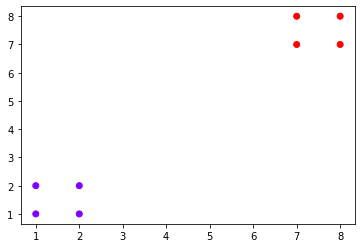

In [458]:
X = np.array(
    [
        [1, 1],
        [1, 2],
        [2, 1],
        [2, 2],

        [7, 7],
        [7, 8],
        [8, 7],
        [8, 8],
    ]
)
y = np.array([0, 0, 0, 0, 1, 1, 1, 1])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')

In [459]:
clf = UKMeans(epsilon=1e-8)
clf.fit(X)

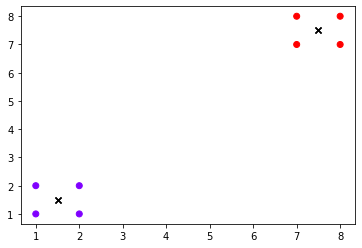

In [460]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1], c='black', marker='x')

# Example 1

In [473]:
rng = np.random.default_rng(seed=1)

mu = {
    1: np.array([5, 2]),
    2: np.array([3, 4]),
    3: np.array([8, 4]),
    4: np.array([6, 6]),
    5: np.array([10, 8]),
    6: np.array([7, 10]),
}

sigma = np.array([
    [0.4, 0],
    [0, 0.4],
])

X = np.zeros((400, 2))
y = np.zeros(400)
for i in range(400):
    c = rng.integers(1, 7)
    X[i] = rng.multivariate_normal(mu[c], sigma)
    y[i] = c


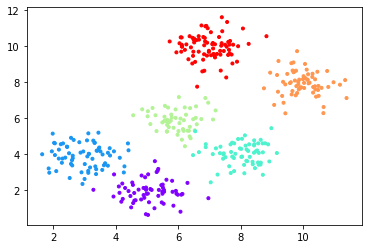

In [474]:
plt.scatter(X[:, 0], X[:, 1], c=y, marker='.', cmap='rainbow')


In [487]:
clf = UKMeans(epsilon=1e-5)
clf.fit(X)

In [488]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {homogeneity_score(y, clf.predict(X))}")

iteration: 13, number of clusters: 6, AR: 0.9713767487195653


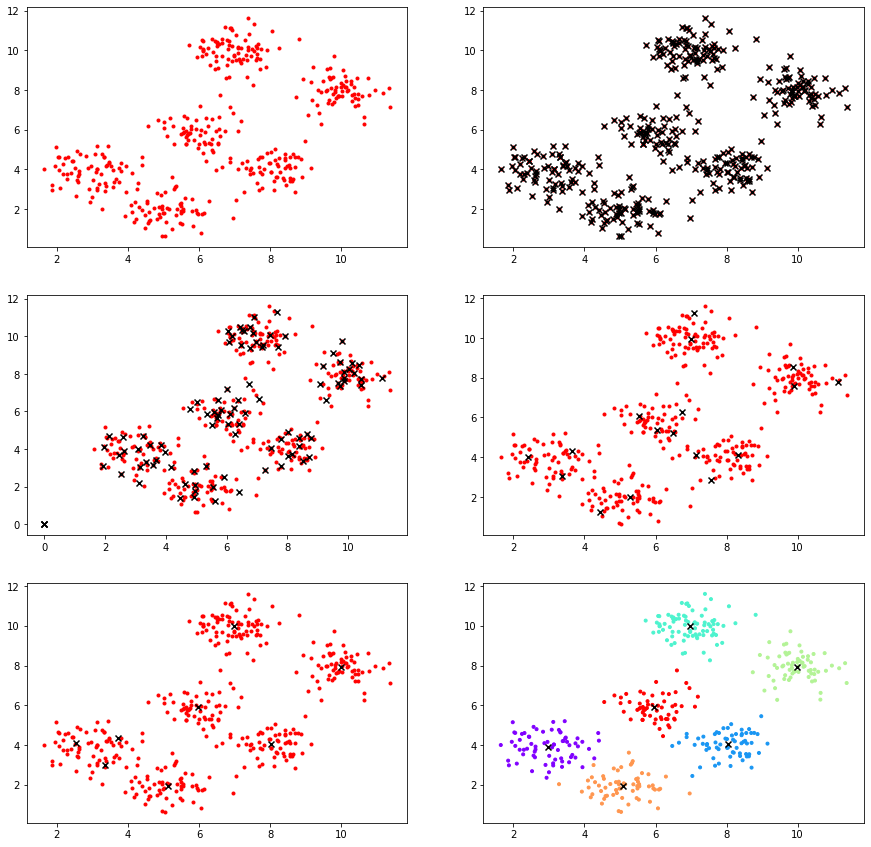

In [489]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(3, 2, 1)
ax.scatter(X[:, 0], X[:, 1], c='red', marker='.')

ax = fig.add_subplot(3, 2, 2)
ax.scatter(X[:, 0], X[:, 1], c='red', marker='.')
ax.scatter(clf.record[0]['centroids'][:,0], clf.record[0]['centroids'][:,1], c='black', marker='x')

ax = fig.add_subplot(3, 2, 3)
ax.scatter(X[:, 0], X[:, 1], c='red', marker='.')
ax.scatter(clf.record[1]['centroids'][:,0], clf.record[1]['centroids'][:,1], c='black', marker='x')

ax = fig.add_subplot(3, 2, 4)
ax.scatter(X[:, 0], X[:, 1], c='red', marker='.')
ax.scatter(clf.record[3]['centroids'][:,0], clf.record[3]['centroids'][:,1], c='black', marker='x')

ax = fig.add_subplot(3, 2, 5)
ax.scatter(X[:, 0], X[:, 1], c='red', marker='.')
ax.scatter(clf.record[8]['centroids'][:,0], clf.record[8]['centroids'][:,1], c='black', marker='x')

ax = fig.add_subplot(3, 2, 6)
ax.scatter(X[:, 0], X[:, 1], c=clf.predict(X), marker='.', cmap='rainbow')
ax.scatter(clf.centroids[:, 0], clf.centroids[:, 1], c='black', marker='x')

## With noisy dataset

In [12]:
rng = np.random.default_rng(seed=1)
for i in range(50):
    noise = rng.uniform(-2,2,(1,2))
    c = rng.integers(1, 7)

    X = np.concatenate((X, noise+mu[c]))
    y = np.concatenate((y, [c]))


In [13]:
clf = UKMeans(epsilon=1e-5)
clf.fit(X)

In [14]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {homogeneity_score(y, clf.predict(X))}")

iteration: 11, number of clusters: 6, AR: 0.9351052496475726


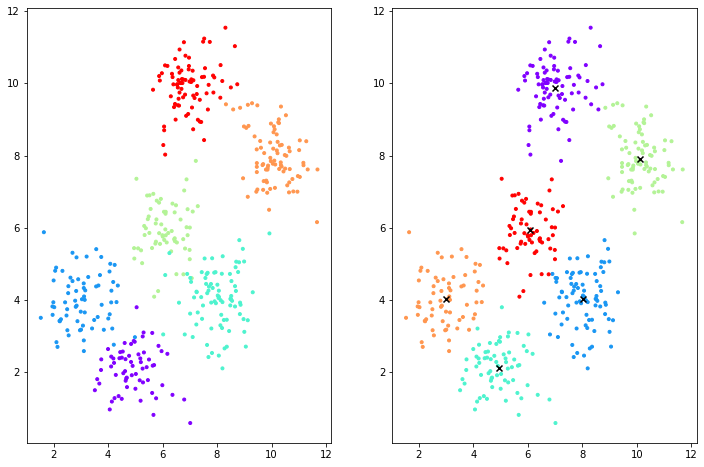

In [15]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:, 0], X[:, 1], c=y, marker='.', cmap='rainbow')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(X[:, 0], X[:, 1], c=clf.predict(X), marker='.', cmap='rainbow')
ax.scatter(clf.centroids[:, 0], clf.centroids[:, 1], c='black', marker='x')

# Example 2

In [490]:
# rng = np.random.default_rng(seed=1)

# mu = {
#     1: np.array([16, 15, 13]),
#     2: np.array([16, 10, 13]),
    
#     3: np.array([10, 20, 10]),
#     4: np.array([10, 15, 9]),
#     5: np.array([10, 10, 9]),

#     6: np.array([6, 20, 6]),
#     7: np.array([6, 15, 5]),
#     8: np.array([6, 10, 5]),
#     9: np.array([8, 5, 5]),
#     10: np.array([8, 0, 5]),

#     11: np.array([3, 20, 2]),
#     12: np.array([3, 15, 2]),
#     13: np.array([0, 15, 4]),
#     14: np.array([0, 10, 4]),
# }

# sigma = np.eye(3)

# X = np.zeros((800, 3))
# y = np.zeros(800)
# for i in range(800):
#     c = rng.integers(1, 15)
#     X[i] = rng.multivariate_normal(mu[c], sigma)
#     y[i] = c

X, y = make_blobs(n_samples=800, center_box=(-2,20), centers=14, cluster_std=0.60, n_features=3, random_state=0)


In [491]:
clf = UKMeans(epsilon=1e-9)
clf.fit(X)


In [492]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {homogeneity_score(y, clf.predict(X))}")

iteration: 11, number of clusters: 14, AR: 0.9976071910071046


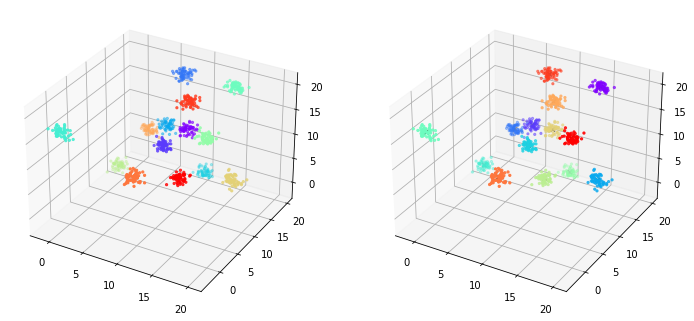

In [19]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, marker='.', cmap='Paired')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clf.predict(X), marker='.', cmap='Paired')
ax.scatter(clf.centroids[:, 0], clf.centroids[:, 1], clf.centroids[:, 2], c='black', marker='x')


# Example 3

## paper

In [70]:
rng = np.random.default_rng(seed=1)

alpha = [0.2, 0.3, 0.1, 0.1, 0.2, 0.1]

mu = {
    1: np.array([2, 4, 6, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 3, 5, 0, 0, 1]),
    2: np.array([0, 1, 3, 5, 0.1, 0.1, 0.5, 0.5, 0, 0, 2, 4, 3, 1, 1, 1, 0.25, 0.5, 0.7, 2.5]),
    3: np.array([5, 5, 5, 5, 4, 4, 4, 4, 6, 6, 6, 6, 8, 8, 8, 8, 1, 1, 1, 1]),
    4: np.array([2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7]),
    5: np.array([1.25, 1.3, 1.45, 1.5, 2.25, 2.3, 2.45, 2.5, 1, 1, 1, 1, 3, 3, 3, 3, 2, 2, 2, 2]),
    6: np.array([0, 0, 1, 1, 0.5, 0.5, 2.5, 2.5, 5, 5, 1, 1, 5, 5, 0, 0, 0.75, 1.5, 3.5, 5.5]),
}

cov = np.eye(20)

centers = list(mu.values())
X, y = make_blobs(n_samples=900, centers=centers, cluster_std=1, n_features=20, random_state=0)

In [71]:
clf = UKMeans(epsilon=1e-4)
clf.fit(X)

In [72]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {homogeneity_score(y, clf.predict(X))}")

iteration: 11, number of clusters: 6, AR: 1.0


# Example 4

In [493]:
def is_inside_square(p, cneter, side):
    return np.all(p >= cneter-side/2) and np.all(p <= cneter+side/2)


def generate_square(samples, centers, sides, angle):
    r = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
    X = np.zeros((samples, centers.shape[1]))
    y = np.zeros(samples)
    for i in range(samples):
        c = rng.integers(9)
        cov = np.eye(2)*sides[c]
        p = rng.multivariate_normal(np.array([0,0]), cov)
        while not is_inside_square(p, np.array([0,0]), sides[c]):
            p = rng.multivariate_normal(np.array([0,0]), cov)
        X[i] = r@p
        X[i] += centers[c]
        y[i] = c
    return X, y


In [494]:
centers = np.array([
    [-1, 0],
    [1, 0],
    [3, 0],

    [-1, 2],
    [1, 2],
    [3, 2],

    [-1, 4],
    [1, 4],
    [3, 4],
])
X, y = generate_square(3000, centers=centers, sides=[1.5]*9, angle=np.pi/4)


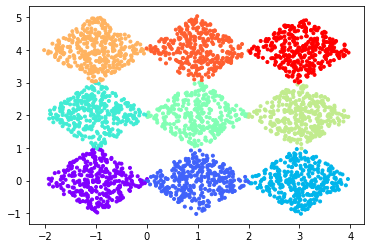

In [495]:
plt.scatter(X[:, 0], X[:, 1], c=y, marker='.', cmap='rainbow')

In [496]:
clf = UKMeans(epsilon=1e-4)
clf.fit(X)

In [497]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {homogeneity_score(y, clf.predict(X))}")

iteration: 15, number of clusters: 9, AR: 0.9911312095331072


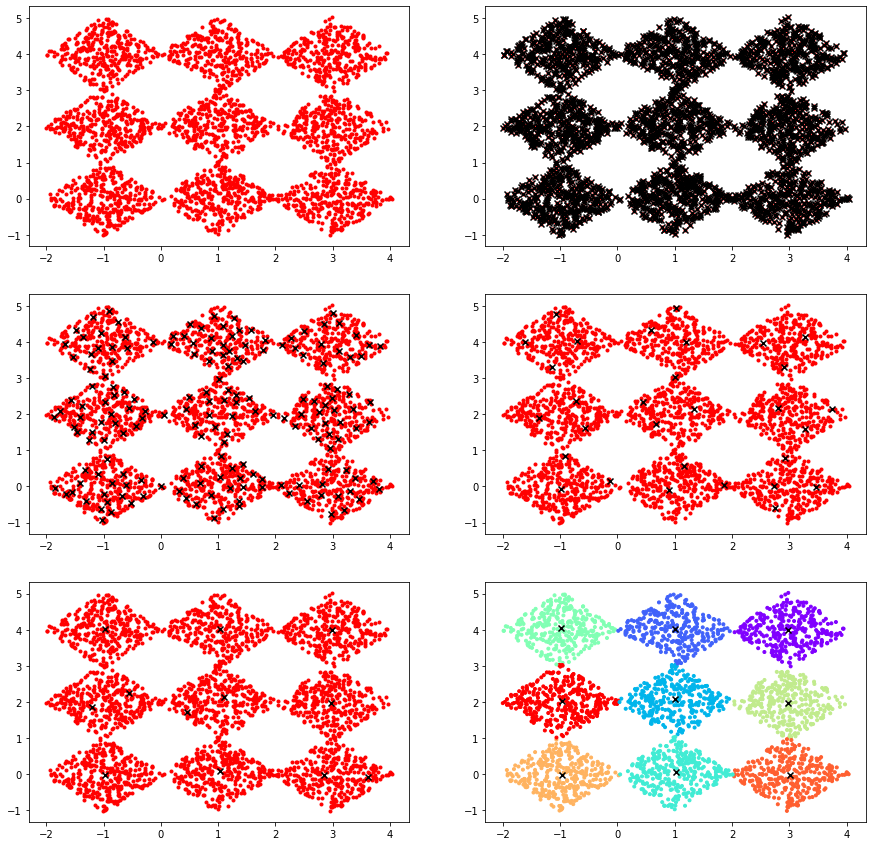

In [144]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(3, 2, 1)
ax.scatter(X[:, 0], X[:, 1], c='red', marker='.')

ax = fig.add_subplot(3, 2, 2)
ax.scatter(X[:, 0], X[:, 1], c='red', marker='.')
ax.scatter(clf.record[0]['centroids'][:,0], clf.record[0]['centroids'][:,1], c='black', marker='x')

ax = fig.add_subplot(3, 2, 3)
ax.scatter(X[:, 0], X[:, 1], c='red', marker='.')
ax.scatter(clf.record[2]['centroids'][:,0], clf.record[2]['centroids'][:,1], c='black', marker='x')

ax = fig.add_subplot(3, 2, 4)
ax.scatter(X[:, 0], X[:, 1], c='red', marker='.')
ax.scatter(clf.record[4]['centroids'][:,0], clf.record[4]['centroids'][:,1], c='black', marker='x')

ax = fig.add_subplot(3, 2, 5)
ax.scatter(X[:, 0], X[:, 1], c='red', marker='.')
ax.scatter(clf.record[6]['centroids'][:,0], clf.record[6]['centroids'][:,1], c='black', marker='x')

ax = fig.add_subplot(3, 2, 6)
ax.scatter(X[:, 0], X[:, 1], c=clf.predict(X), marker='.', cmap='rainbow')
ax.scatter(clf.centroids[:, 0], clf.centroids[:, 1], c='black', marker='x')

# Example 5
## IRIS

In [506]:
X, y = load_iris(return_X_y=True)
# X = NMF(init='', max_iter=10000, shuffle=False).fit_transform(X)
clf = UKMeans(epsilon=1e-1)
clf.fit(X)

In [507]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {metrics.homogeneity_score(y, clf.predict(X))}")

iteration: 8, number of clusters: 3, AR: 0.7362143719137068


## seeds

In [520]:
seeds_df = pd.read_csv("datasets/seeds_dataset.txt", header=None, delimiter="\t")
X,y = seeds_df.iloc[:,:-1].to_numpy(), seeds_df.iloc[:,-1].to_numpy()
# X = NMF(init=None, max_iter=10000, shuffle=False).fit_transform(X)
clf = UKMeans(epsilon=1e-5)
clf.fit(X)

In [521]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {metrics.homogeneity_score(y, clf.predict(X))}")

iteration: 16, number of clusters: 3, AR: 0.7000585716643524


## austrailian

In [522]:
aus_df = pd.read_csv('datasets/australian.dat', header=None, delimiter=" ")
X, y = aus_df.iloc[:,:-1].to_numpy(), aus_df.iloc[:,-1].to_numpy()
X = NMF(init=None, max_iter=1000, shuffle=False).fit_transform(X)
clf = UKMeans(epsilon=1e0)
clf.fit(X)

In [524]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {metrics.homogeneity_score(y, clf.predict(X))}")

iteration: 3, number of clusters: 11, AR: 0.13429332417192752


## Flowmeter D

In [525]:
flowmeter_df = pd.read_csv('datasets/Meter D', header=None, delimiter="\t")
X, y = flowmeter_df.iloc[:,:-1].to_numpy(), flowmeter_df.iloc[:,-1].to_numpy()
flowmeter_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,...,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,1.411731,1.166684,1.188470,4.475259,4.890867,4.910373,3.266045,1487.287238,1484.539830,1485.889306,...,12.504306,124.020073,123.821264,151.796256,151.411492,151.681565,151.092505,122.045856,120.976574,2.588889
std,0.904196,3.189220,0.675639,2.183965,2.357263,2.229163,2.944863,10.828438,10.910521,7.462522,...,20.331656,1.403897,1.036510,1.677263,1.279263,0.872729,0.895633,4.713213,6.406887,1.176060
min,-2.474166,-37.780488,-2.275649,-2.617222,-2.124444,-0.190000,-3.028611,1441.675000,1413.877778,1458.702778,...,-1.000000,111.804444,121.059167,140.902222,149.773889,147.680000,146.737778,99.679444,97.809167,1.000000
25%,1.085364,0.999759,0.992503,3.377778,3.703611,3.660764,0.373194,1483.476389,1483.579861,1483.596528,...,-0.700000,124.143889,123.719792,151.632917,151.021042,151.587639,150.962153,118.698194,118.818958,1.000000
50%,1.093996,1.005958,0.998655,4.859306,5.604306,5.609861,3.398194,1484.890278,1484.918056,1484.847222,...,-0.700000,124.374306,123.858194,151.930833,151.189444,151.880000,151.128333,124.364583,123.911667,3.000000
75%,1.207706,1.020066,1.007719,6.250347,6.815278,6.771667,6.194306,1486.661806,1486.586806,1486.588194,...,44.200000,124.487361,124.031181,152.064097,151.415278,152.012431,151.350903,124.567153,124.057361,4.000000
max,5.911308,11.191656,3.314103,8.041111,8.667222,8.622500,7.941944,1552.372222,1523.722222,1512.719444,...,45.100000,128.273056,127.807500,161.174167,160.737222,154.210833,154.225278,124.886111,124.396389,4.000000


In [529]:
# X = NMF(init='nndsvd', max_iter=1000, shuffle=False).fit_transform(X)
clf = UKMeans(epsilon=1e-4)
clf.fit(X)

In [530]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {metrics.homogeneity_score(y, clf.predict(X))}")

iteration: 25, number of clusters: 2, AR: 0.44489347787444566


## Wine

In [535]:
# wine_df = pd.read_csv('datasets/wine.data', header=None, delimiter=",")
wine_df = load_wine(as_frame=True).frame
X, y = wine_df.iloc[:,:-1].to_numpy(), wine_df.iloc[:,-1].to_numpy()
X = NMF(init='nndsvd', max_iter=10000, shuffle=True).fit_transform(X)
clf = UKMeans(epsilon=1e-8)
clf.fit(X)

In [536]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {metrics.homogeneity_score(y, clf.predict(X))}")

iteration: 13, number of clusters: 3, AR: 0.4393952254781283


## Horse

the paper does not mention how it handles the missing values 

In [265]:
horse_df = pd.read_csv('datasets/horse-colic.data', header=None, delimiter=" ")
horse_df.replace('?', np.nan, inplace=True)
horse_df.dropna(axis=1,inplace=True)
horse_df.describe()
# X, y = horse_df.iloc[:,:-1].to_numpy(), horse_df.iloc[:,-1].to_numpy()
# clf = UKMeans(epsilon=1e0)
# clf.fit(X)


,1,2,23,24,25,26,27
count,300.000000,3.000000e+02,300.000000,300.000000,300.000000,300.000000,300.000000
mean,1.640000,1.085889e+06,1.363333,3657.880000,90.226667,7.363333,1.670000
std,2.173972,1.529801e+06,0.481763,5399.513513,649.569234,127.536674,0.470998
min,1.000000,5.184760e+05,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,5.289040e+05,1.000000,2111.750000,0.000000,0.000000,1.000000
50%,1.000000,5.303055e+05,1.000000,2673.500000,0.000000,0.000000,2.000000
75%,1.000000,5.347275e+05,2.000000,3209.000000,0.000000,0.000000,2.000000
max,9.000000,5.305629e+06,2.000000,41110.000000,7111.000000,2209.000000,2.000000


In [ ]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {metrics.homogeneity_score(y, clf.predict(X))}")

## Waveform V1

In [267]:
wave_df = pd.read_csv('datasets/waveform.data', header=None, delimiter=",")
X, y = wave_df.iloc[:,:-1].to_numpy(), wave_df.iloc[:,-1].to_numpy()
# X = NMF(init='nndsvd', max_iter=10000, shuffle=False).fit_transform(X)
clf = UKMeans(epsilon=1e-8)
clf.fit(X)

In [269]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {metrics.homogeneity_completeness_v_measure(y, clf.predict(X))}")

iteration: 71, number of clusters: 4, AR: (0.4610110117457123, 0.37731300584600896, 0.4149838175210172)


# Example 6

## SPECT

In [636]:
spect_df = pd.read_csv('datasets/SPECT.test', header=None, delimiter=',')
X, y = spect_df.iloc[:,1:].to_numpy(), spect_df.iloc[:,0].to_numpy()
# X = NMF(init='nndsvd', max_iter=10000, shuffle=False).fit_transform(X)
clf = UKMeans(epsilon=1e-1)
clf.fit(X)

In [637]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}")

iteration: 6, number of clusters: 1


## Parkinson

In [638]:
parkinson_df = pd.read_csv('datasets/parkinsons.data', header=0, delimiter=",")
parkinson_df.drop(parkinson_df.columns[0], axis=1, inplace=True)
X, y = parkinson_df.drop('status',axis=1).to_numpy(), parkinson_df.loc[:,'status'].to_numpy()
# X = NMF(init='nndsvd', max_iter=10000, shuffle=False).fit_transform(X)
clf = UKMeans(epsilon=1e-8)
clf.fit(X)

In [639]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {metrics.homogeneity_score(y, clf.predict(X))}")

iteration: 28, number of clusters: 2, AR: 0.12148622512718067


## WPBC

In [563]:
wpbc_df = pd.read_csv('datasets/wpbc.csv', header=0, delimiter=",")
wpbc_df.drop(wpbc_df.columns[0], axis=1, inplace=True)
wpbc_df.drop(wpbc_df.columns[-1], axis=1, inplace=True)
wpbc_df.replace('M', 0, inplace=True)
wpbc_df.replace('B', 1, inplace=True)
X, y = wpbc_df.iloc[:,1:].to_numpy(), wpbc_df.iloc[:, 0].to_numpy()
# X = NMF(init='nndsvd', max_iter=10000, shuffle=False).fit_transform(X)
clf = UKMeans(epsilon=1e-8)
clf.fit(X)

In [564]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}, AR: {metrics.homogeneity_completeness_v_measure(y, clf.predict(X))}")

iteration: 52, number of clusters: 2, AR: (0.4222907124699913, 0.5168089972809707, 0.46479332792160805)


## Colon

dataset with the specified samples (62) and features (2000) was not found in UCI repository

## Lung

dataset with the specified samples (203) and features (3312) was not found in UCI repository

## Nci9

dataset with the specified samples (60) and features (9712) was not found in UCI repository

# Example 7

## Yale faces

In [729]:
rng = np.random.default_rng(1)
images = loadmat('datasets/Yale_32x32.mat')
idx = rng.choice(images['fea'].shape[0], size=135, replace=False)
X, y = images['fea'][idx], images['gnd'].ravel()[idx]
X = PCA(n_components=20).fit_transform(X)
clf = UKMeans(epsilon=1e-8)
clf.fit(X)

In [730]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}")

iteration: 9, number of clusters: 15


# Example 8

## CIFAR-10

In [582]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [731]:
cifar_df = unpickle(
    'datasets/cifar-10-python/cifar-10-batches-py/data_batch_2')

# discard first hunderd rows
data, labels = cifar_df[b'data'][100:], np.array(cifar_df[b'labels'][100:])
X = np.concatenate((
    data[labels == 0, :][:10],
    data[labels == 1, :][:10],
    data[labels == 2, :][:10],
    data[labels == 3, :][:10],
    data[labels == 4, :][:10],
    data[labels == 5, :][:10],
    data[labels == 6, :][:10],
    data[labels == 7, :][:10],
    data[labels == 8, :][:10],
    data[labels == 9, :][:10],
))

y = np.concatenate((
    np.zeros(10),
    np.ones(10),
    np.ones(10) * 2,
    np.ones(10) * 3,
    np.ones(10) * 4,
    np.ones(10) * 5,
    np.ones(10) * 6,
    np.ones(10) * 7,
    np.ones(10) * 8,
    np.ones(10) * 9,
))


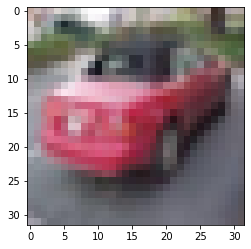

In [600]:
img = np.zeros((1024, 3))
img[:,0] = data[0, :1024]
img[:,1] = data[0, 1024:2048]
img[:,2] = data[0, 2048:]
img.astype(np.uint8)
plt.imshow(img.astype(np.uint8).reshape(32, 32, -1))

In [732]:
clf = UKMeans(epsilon=1e-10)
clf.fit(X)

/tmp/ipykernel_10208/3391217340.py:45: RuntimeWarning: overflow encountered in double_scalars
  eta = min(1, 1/self.t**(np.floor(X.shape[1]/2 - 1)))


In [733]:
print(f"iteration: {clf.t}, number of clusters: {clf.n_centers}")

iteration: 5, number of clusters: 8
